In [2]:
from skimage import io,transform
import glob
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import time

import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


# GPU Parameter settings
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
config = tf.ConfigProto(allow_soft_placement=True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)


# Data set address
path = "./fruits/"
# Save model
model_path = "./module/model"
# Save the structure of network.
log_path = "./log"


# Set the size of the input picture (width 100 * height 100 * 3)
w = 100
h = 100
c = 3



In [3]:
# Load the data set
def read_image(path):

    global w
    global h
    global c
    cate = [path + x for x in os.listdir(path) if os.path.isdir(path+x)]
    images = []
    labels = []
    #Read image.jpg
    for index, folder in enumerate(cate):
        for im in glob.glob(folder + '/*.jpg'):
            img = io.imread(im)
            img = transform.resize(img, (w, h))
            images.append(img)
            labels.append(index)
    return np.asarray(images, np.float32), np.asarray(labels, np.int32)


data, label = read_image(path)
# Disorder the data set
num_example = data.shape[0]
array = np.arange(num_example)
np.random.shuffle(array)
data = data[array]
label = label[array]
# Randomly divide the data set into training set and test
#70% of the sample is training set (training set:test = 7:3)
sample = np.int(num_example * 0.7)  
x_train = data[: sample]
y_train = label[: sample]
x_val = data[sample:]
y_val = label[sample:]


# Record parameters
def variable_summaries(var):

    with tf.name_scope('summaries'):
        # Record the mean by useing tf.summary.scaler
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        # Record the standard deviation
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        # Record the standard deviation, max value, min value 
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        # Record parameters with histogram
        tf.summary.histogram('histogram', var)
        
        

C:\Users\admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\admin\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [4]:
# Construction of LeNet-5 convolution neural network
def inference(input_tensor, train, regularizer):

    # First layer, convolution layer
    # Make input (100 * 100 * 3).
    with tf.variable_scope('layer1-conv1'):
        conv1_weights = tf.get_variable("weight", [5, 5, 3, 64],initializer=tf.truncated_normal_initializer(stddev=0.1))
        variable_summaries(conv1_weights)
        conv1_biases = tf.get_variable("bias", [64], initializer=tf.constant_initializer(0.0))
        variable_summaries(conv1_biases)
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        tf.summary.histogram('relu1', relu1)

    # Second layer, pooling layer 
    # Make input (100 * 100 * 64) into output (50 * 50 * 64) and flattening treatment.
    with tf.name_scope("layer2-pool1"):
        pool1 = tf.nn.max_pool(relu1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
        tf.summary.histogram('pool1', pool1)

    # Third layer, convolution layer
    # Make input (50 * 50 * 64) into output (50 * 50 * 128).
    with tf.variable_scope("layer3-conv2"):
        conv2_weights = tf.get_variable("weight", [5, 5, 64, 128], initializer=tf.truncated_normal_initializer(stddev=0.1))
        variable_summaries(conv2_weights)
        conv2_biases = tf.get_variable("bias", [128], initializer=tf.constant_initializer(0.0))
        variable_summaries(conv2_biases)
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        tf.summary.histogram('relu2', relu2)

    # Fourth layer, pooling layer
    # Make input (50 * 50 * 128) into output (25 * 25 * 128) and flattening treatment.
    with tf.name_scope("layer4-pool2"):
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        nodes = 25 * 25 * 128
        reshaped = tf.reshape(pool2, [-1, nodes])
        tf.summary.histogram('pool2', pool2)


    # Fifth layer, full connection layer (1024 hidden nodes)
    with tf.variable_scope('layer5-fc1'):
        fc1_weights = tf.get_variable("weight", [nodes, 1024], initializer=tf.truncated_normal_initializer(stddev=0.1))
        variable_summaries(fc1_weights)
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable("bias", [1024], initializer=tf.constant_initializer(0.1))
        variable_summaries(fc1_biases)
        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        # Using dropout to reduce the degree of over-fitting and under-fitting.
        # Dropout 40% of sample
    if train:
        fc1 = tf.nn.dropout(fc1, 0.4)
        tf.summary.histogram('fc1', fc1)

    # Sixth layer, full connection layer (512 hidden nodes)
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable("weight", [1024, 512], initializer=tf.truncated_normal_initializer(stddev=0.1))
        variable_summaries(fc2_weights)
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable("bias", [512], initializer=tf.constant_initializer(0.1))
        variable_summaries(fc2_biases)
        fc2 = tf.nn.relu(tf.matmul(fc1, fc2_weights) + fc2_biases)
        # Using dropout to reduce the degree of over-fitting and under-fitting.
        # Dropout 40% of sample
    if train:
        fc2 = tf.nn.dropout(fc2, 0.4)
        tf.summary.histogram('fc2', fc2)

    # Seventh layer, full connection layer (output three classifications)
    with tf.variable_scope('layer7-fc3'):
        fc3_weights = tf.get_variable("weight", [512, 3], initializer=tf.truncated_normal_initializer(stddev=0.1))
        variable_summaries(fc3_weights)
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(fc3_weights))
        fc3_biases = tf.get_variable("bias", [3], initializer=tf.constant_initializer(0.1))
        variable_summaries(fc3_biases)
        
        # Save the weights and biases in the logit.
        logit = tf.matmul(fc2, fc3_weights) + fc3_biases
        tf.summary.histogram('logit', logit)
        
    return logit



In [5]:
# Set the size and format of input parameters
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, w, h, c], name='x')
y = tf.placeholder(tf.int32, shape=[None, ], name='y')


# Regularization parameters (0.0001)
regularizer = tf.contrib.layers.l2_regularizer(0.0001)
logits = inference(x, True, regularizer)
b = tf.constant(value=1, dtype=tf.float32)
logits_tag = tf.multiply(logits, b, name='logits_tag')

# Lose function
with tf.name_scope('loss'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    
  # AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cross_entropy)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)


# Data generator
def get_feed_data(inputs=None, targets=None, batch_size=None, shuffle=False):

    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]
        
        

W0919 11:26:50.877514  5984 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0919 11:26:51.020164  5984 deprecation.py:506] From <ipython-input-4-f4243b5eb56c>:53: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0919 11:26:51.020164  5984 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0919 11:26:51.078010  5984 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In Te

In [6]:
# Initialize and start training
start = time.time()
# Epoch times
epoch = 50
# Batch size
batch_size = 64
saver = tf.train.Saver()
sess = tf.Session()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(log_path, sess.graph)
sess.run(tf.global_variables_initializer())
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for i in range(epoch):
    # training set
    train_loss, train_acc, n_batch = 0, 0, 0
    for x_train_a, y_train_a in get_feed_data(x_train, y_train, batch_size, shuffle=True):
        _, err, ac = sess.run([optimizer, cross_entropy, accuracy], feed_dict={x: x_train_a, y: y_train_a})
        train_loss += err
        train_acc += ac
        n_batch += 1
    print("Epoch: %02d" % (i + 1) + " train loss: %f, train accuracy: %f" % (np.sum(train_loss) / n_batch, np.sum(train_acc) / n_batch))
    train_loss_history.append(np.sum(train_loss) / n_batch)
    train_acc_history.append(np.sum(train_acc) / n_batch)
    
    # test
    val_loss, val_acc, n_batch = 0, 0, 0
    for x_val_a, y_val_a in get_feed_data(x_val, y_val, batch_size, shuffle=False):
        summary, err, ac = sess.run([merged, cross_entropy, accuracy], feed_dict={x: x_val_a, y: y_val_a})
        val_loss += err
        val_acc += ac
        writer.add_summary(summary, i)
        n_batch += 1
    print("Epoch: %02d" % (i + 1) + " validation loss: %f, validation accuracy: %f" % (np.sum(val_loss) / n_batch, np.sum(val_acc) / n_batch))
    val_loss_history.append(np.sum(val_loss) / n_batch)
    val_acc_history.append(np.sum(val_acc) / n_batch)
    
    
print("training finished.")
saver.save(sess, model_path)
writer.close()
sess.close()


end = time.time()
totalTime = end - start
print("Total time is: %.2f seconds" % (totalTime))



Epoch: 01 train loss: 7557.749132, train accuracy: 0.371528
Epoch: 01 validation loss: 745.726929, validation accuracy: 0.480469
Epoch: 02 train loss: 403.098633, train accuracy: 0.500000
Epoch: 02 validation loss: 137.380112, validation accuracy: 0.605469
Epoch: 03 train loss: 114.795098, train accuracy: 0.604167
Epoch: 03 validation loss: 82.390411, validation accuracy: 0.609375
Epoch: 04 train loss: 57.273682, train accuracy: 0.668403
Epoch: 04 validation loss: 48.837330, validation accuracy: 0.734375
Epoch: 05 train loss: 39.027032, train accuracy: 0.776042
Epoch: 05 validation loss: 41.819469, validation accuracy: 0.777344
Epoch: 06 train loss: 30.768711, train accuracy: 0.815972
Epoch: 06 validation loss: 61.185978, validation accuracy: 0.722656
Epoch: 07 train loss: 30.779334, train accuracy: 0.807292
Epoch: 07 validation loss: 33.932499, validation accuracy: 0.796875
Epoch: 08 train loss: 25.126872, train accuracy: 0.852431
Epoch: 08 validation loss: 28.458420, validation accur

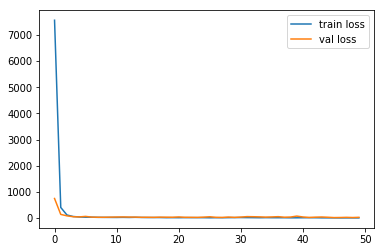

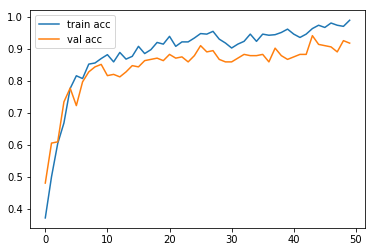

In [7]:
# plot Loss and Accuracies
# loss
plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(train_acc_history, label='train acc')
plt.plot(val_acc_history, label='val acc')
plt.legend()
plt.show()



In [8]:
# Get the labels of the test images.

test_labels = test_batches.classes
# We need these to plot the confusion matrix.
test_labels
# Print the label associated with each class
test_batches.class_indices

NameError: name 'test_batches' is not defined

In [ ]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

In [ ]:
predictions.shape

In [ ]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

test_batches.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')